In [726]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, stats, optimize

import math

from tqdm import tqdm

SEED = 12312512


In [433]:
def l(func_int, inverse_int_func, random_num, a, *args):
    return inverse_int_func((1-random_num) * func_int(a, args), args)

## Primeri funkcij

### $p(l) = \frac{1}{l^{\mu}} $

To funkcijo je dost uizi integrerat
Integral funkcijo je pac
$ P(L) = \frac{1}{(1-\mu) l^{\mu-1}} $

In [942]:
def p(l, mu):
    return

def P(l, mu):
    mu = mu[0]
    return 1 / ((1-mu) * l ** (mu-1))

def inverseP(y, mu):
    mu = mu[0]
    return (1 / ((1-mu) * y))**(1/(mu-1))

Just some random histograms, to check the distribution

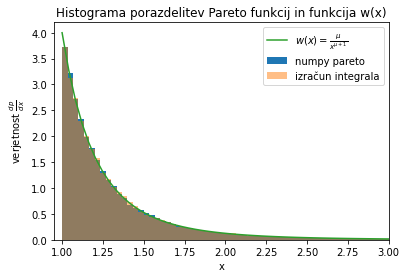

In [946]:
MU = 4
a = 1
bins = 60

x = np.random.random(100000)
y = np.array([l(P, inverseP, x_k, a, MU+1) for x_k in x])

y_pareto = np.random.pareto(MU, size=len(x))+a
# plt.scatter(x, y)

y = y[y < 3]
y_pareto = y_pareto[y_pareto < 3]

plt.hist(y_pareto, bins=bins, density=True, label='numpy pareto')
plt.hist(y, density=True, alpha=0.5, bins=bins, label='izračun integrala')

x = np.linspace(1,3)
f_x = (MU)*x**(-MU-1)
plt.plot(x, f_x, label=r'$w(x) = \frac{\mu}{x^{\mu+1}}$')

plt.xlim([0.95, 3])
plt.legend()

plt.xlabel('x')
plt.ylabel(r'verjetnost $\frac{dp}{dx}$')

plt.title('Histograma porazdelitev Pareto funkcij in funkcija w(x)')

plt.savefig('./outputs/hist_pareto.pdf', bbox_inches='tight')

plt.show()


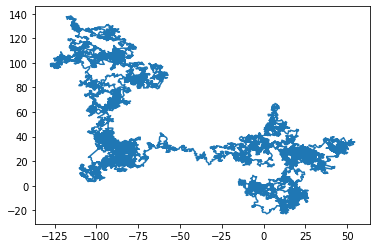

In [815]:
# np.random.seed(SEED)
MU = 5

STEPS = 10000
x, y = np.array([0]), np.array([0])

for i in range(STEPS):
    phi = np.random.random() * 2 * np.pi
    # l = np.random.random()
    # l_i = l(P, inverseP, np.random.random(), 10, MU)
    l_i = np.random.pareto(MU-1) + 1

    x = np.append(x, x[i] + l_i * np.cos(phi))
    y = np.append(y, y[i] + l_i * np.sin(phi))

plt.plot(x, y)
plt.show()


## Najvaznejsi funkciji

Sigma x in y sta logicno enaki ter neodvisni, zato ju lahko kvadratno sestejemo. To da sta enaki sledi iz dejstva, da je izbira kota uniformna funkcija. Torej je vbistvu vseeno, če bi gledali samo eno dimenzijo. Vendar potem nebi mogli dobiti takih lepih 2d grafov.

In [948]:
# M korakov, N vzporednih poskusov
def flight_mad(M, N, mu, draw=False, save=""):
    X = np.zeros((M, N))
    Y = np.zeros((M, N))
    MADs = np.zeros(M)
    for m in range(1, M):
        phi = np.random.random(N) * 2 * np.pi
        l_i = np.random.pareto(mu-1, size=N) + 1
        X[m] = X[m-1] + l_i * np.cos(phi)
        Y[m] = Y[m-1] + l_i * np.sin(phi)
        MADs[m]=np.sqrt(stats.median_abs_deviation(X[m])**2 + stats.median_abs_deviation(Y[m])**2)


    if draw:
        plt.plot(X[:, 0], Y[:, 0], label=f'M = {M}; $\mu$ = {mu}')
        plt.title(f'2D graf poleta z $\mu$ = {mu}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        if save:
            plt.savefig(f"./outputs/{save}.pdf", bbox_inches='tight')
        plt.show()

    return np.arange(M), MADs
        

def walk_mad(M, N, mu, draw=False):
    X = np.zeros((M, N))
    Y = np.zeros((M, N))
    L_ii = np.zeros((2*M, N))
    Phi_ii = np.zeros((2*M, N))

    vt = 1.5

    # najprej zgenereram use dolzine
    # tuki jih zgenereram mal vec da jih nebo premal nakonc
    for m in range(1, 2*M):
        # phi = np.random.random(N) * 2 * np.pi
        # # l_i = l(P, inverseP, np.random.random(), 1, mu)
        # l_i = np.random.pareto(mu-1, size=N) + 1
        Phi_ii[m] = np.random.random(N) * 2 * np.pi
        L_ii[m] = np.random.pareto(mu-1, size=N) + 1
        # X[m] = X[m-1] + l_i * np.cos(phi)
        # Y[m] = Y[m-1] + l_i * np.sin(phi)

    # kr uzemmo za mad M korakov, itak nima veze ker so velke cifre
    MADs = np.zeros(M)

    # za vsako meritev posebi
    for n in range(N):
        m = 0
        orig_m = 0
        leftover_l = 0
        leftover_phi = 0
        for m in range(M-1):
            if not orig_m < 2*M:
                break
            m += 1

            # ce je vecji leftover, se sam premaknemo naprej
            if leftover_l > vt:
                X[m][n] = X[m-1][n] + vt * np.cos(leftover_phi)
                Y[m][n] = Y[m-1][n] + vt * np.sin(leftover_phi)
                leftover_l -= vt

            # ce je mansi leftover ga porabmo ceuga, in gremo na sledn korak
            else: #elif leftover_l < vt:
                X[m][n] = X[m-1][n] + leftover_l * np.cos(leftover_phi)
                Y[m][n] = Y[m-1][n] + leftover_l * np.sin(leftover_phi)

                vt_rest = vt - leftover_l
                leftover_l = 0

                #? ce je dolzina naslednga koraka vecja kt predvidena hitrost
                #? se sam premaknemo za njo naprej in gremo na nasledn korak
                if L_ii[orig_m][n] > vt_rest:
                    X[m][n] = X[m-1][n] + vt_rest * np.cos(Phi_ii[orig_m][n])
                    Y[m][n] = Y[m-1][n] + vt_rest * np.sin(Phi_ii[orig_m][n])

                    leftover_l = L_ii[orig_m][n] - vt_rest
                    leftover_phi = Phi_ii[orig_m][n]

                    orig_m += 1

                #? se ce slucajn zgodi, da je vec naslednih korakov mansih kt vt
                #? pac to sam pomen, da jih mors vec skp sestet
                else:
                    # vt_rest = vt
                    while True:
                        if not orig_m < 2*M:
                            break

                        if L_ii[orig_m][n] < vt_rest:
                            X[m][n] = X[m-1][n] + L_ii[orig_m][n] * \
                                np.cos(Phi_ii[orig_m][n])
                            Y[m][n] = Y[m-1][n] + L_ii[orig_m][n] * \
                                np.sin(Phi_ii[orig_m][n])

                            vt_rest -= L_ii[orig_m][n]
                            orig_m += 1

                        else:
                            X[m][n] = X[m-1][n] + vt_rest * \
                                np.cos(Phi_ii[orig_m][n])
                            Y[m][n] = Y[m-1][n] + vt_rest * \
                                np.sin(Phi_ii[orig_m][n])

                            leftover_l = L_ii[orig_m][n] - vt_rest
                            leftover_phi = Phi_ii[orig_m][n]

                            break


    for m in range(M):
        MADs[m] = np.sqrt(stats.median_abs_deviation(
            X[m])**2 + stats.median_abs_deviation(Y[m])**2)

    MADs = MADs[MADs != 0]

    if draw:
        plt.plot(X[:, 0], Y[:, 0], label=f'M = {M}; $\mu$ = {mu}')
        plt.title(f'2D graf sprehoda z $\mu$ = {mu}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    return np.arange(len(MADs)), MADs


# def walk_mad(M, N, mu, draw=False):
#     X = np.zeros((2*M, N))
#     Y = np.zeros((2*M, N))
#     L_ii = np.zeros((2*M, N))
#     Phi_ii = np.zeros((2*M, N))

#     vt = 1.5

#     # najprej zgenereram use dolzine
#     # tuki jih zgenereram mal vec da jih nebo premal nakonc
#     for m in range(1, 2*M):
#         Phi_ii[m] = np.random.random(N) * 2 * np.pi
#         L_ii[m] = np.random.pareto(mu-1, size=N) + 1
#         X[m] = X[m-1] + L_ii[m] * np.cos(Phi_ii[m])
#         Y[m] = Y[m-1] + L_ii[m] * np.sin(Phi_ii[m])

#     # kr uzemmo za mad M korakov, itak nima veze ker so velke cifre
#     MADs = np.zeros(M)

#     X_walk = np.zeros((M, N))
#     Y_walk = np.zeros((M, N))

#     for n in range(N):
#         for m in range(M):
#             # Li = np.sum(L_ii[:i, n])

#             m_orig = np.argmax(L_ii[:, n] > m*vt)

#             # Li_1 = Li + L_ii[:i+1, n]

#             l = vt*m - L_ii[m_orig, n]
#             X_walk[m][n] = X[m_orig-1][n] + l * np.cos(Phi_ii[m_orig][n])
#             Y_walk[m][n] = Y[m_orig-1][n] + l * np.sin(Phi_ii[m_orig][n])
            
#             m += 1
                
#     for m in range(M):
#         MADs[m] = np.sqrt(stats.median_abs_deviation(
#             X[m])**2 + stats.median_abs_deviation(Y[m])**2)

#     MADs = MADs[MADs != 0]

#     return np.arange(len(MADs)), MADs


In [ ]:
def walk_function_gamma(mu):
    if mu < 2:
        return 2
    if mu < 3:
        return 4 - mu
    else:
        return 1


walk_gamma = lambda x: np.array([walk_function_gamma(i) for i in x])

def flight_function_gamma(mu):
    if mu < 3:
        return 2 / (mu - 1)
    return 1

flight_gamma = np.vectorize(flight_function_gamma)


In [876]:
x, MADs = walk_mad(1000, 100, 1.5)

### Značilni grafi

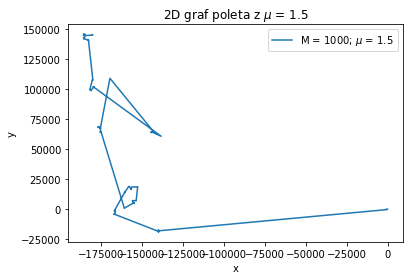

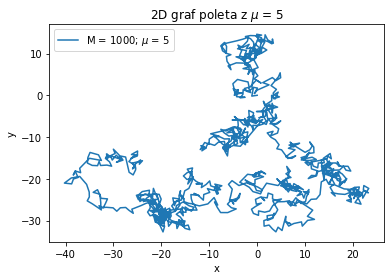

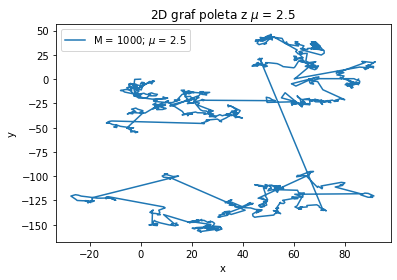

In [949]:
np.random.seed(400)
flight_mad(1000, 1, 1.5, draw=True ,save='2d_flight_mu_1.5')
np.random.seed(10329)
flight_mad(1000, 1, 5, draw=True, save='2d_flight_mu_5')
flight_mad(1000, 1, 2.5, draw=True, save='2d_flight_mu_2.5')

pass


In [856]:
np.random.seed(300)
walk_mad(1000, 1, 1.5, draw=True)
np.random.seed(10329)
walk_mad(1000, 1, 5, draw=True)
walk_mad(1000, 1, 2.5, draw=True)

pass


## FIti

Zdej k mamo funkcije se lahko zacnem igrt s fiti funkcij.

In [623]:
def linear_func(x, k, c):
    return  x*k + c

## Funkcije za gammo

In [755]:
def walk_function_gamma(mu):
    if mu < 2:
        return 2
    if mu < 3:
        return 4 - mu
    else:
        return 1


walk_gamma = lambda x: np.array([walk_function_gamma(i) for i in x])

def flight_function_gamma(mu):
    if mu < 3:
        return 2 / (mu - 1)
    return 1

flight_gamma = np.vectorize(flight_function_gamma)


## Primerjava razspsenost po definiciji in MAD

Tuki notr je se primerjava med MADx in MADy

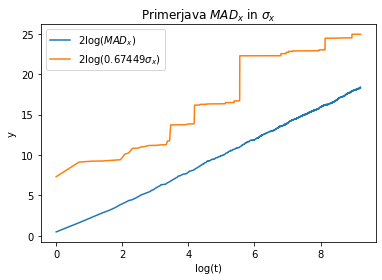

In [971]:
# M korakov, N vzporednih poskusov
def primerjava_madx_mady(M, N, mu):
    X = np.zeros((M, N))
    Y = np.zeros((M, N))
    MADs_x = np.zeros(M)
    Sigma_x = np.zeros(M)
    for m in range(1, M):
        phi = np.random.random(N) * 2 * np.pi
        l_i = np.random.pareto(mu-1, size=N) + 1
        X[m] = X[m-1] + l_i * np.cos(phi)
        Y[m] = Y[m-1] + l_i * np.sin(phi)

        MADs_x[m] = stats.median_abs_deviation(X[m])
        Sigma_x[m] = np.std(X[m])*0.67449
        
        # np.sqrt( + stats.median_abs_deviation(Y[m])**2)

    return np.arange(M), MADs_x, Sigma_x


x, MADs_x, Sigma_x = primerjava_madx_mady(10000, 1000, 2)
x_x, y_x = np.log(x[1:]), 2*np.log(MADs_x[1:])
x_y, y_y = np.log(x[1:]), 2*np.log(Sigma_x[1:])

plt.plot(x_x, y_x, label='$2 \log(MAD_x)$')
plt.plot(x_y, y_y, label='$2 \log(0.67449\sigma_x)$')

plt.xlabel('log(t)')
plt.ylabel('y')
plt.title('Primerjava $MAD_x$ in $\sigma_x$')
plt.legend()
plt.savefig(f"./outputs/sigmax_madx.pdf", bbox_inches='tight')

plt.show()


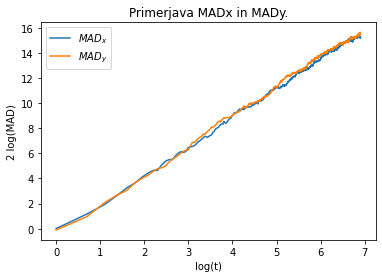

In [972]:
# M korakov, N vzporednih poskusov
def primerjava_sigma_mad(M, N, mu):
    X = np.zeros((M, N))
    Y = np.zeros((M, N))
    MADs_x = np.zeros(M)
    MADs_y = np.zeros(M)
    for m in range(1, M):
        phi = np.random.random(N) * 2 * np.pi
        l_i = np.random.pareto(mu-1, size=N) + 1
        X[m] = X[m-1] + l_i * np.cos(phi)
        Y[m] = Y[m-1] + l_i * np.sin(phi)

        MADs_x[m] = stats.median_abs_deviation(X[m])**2
        MADs_y[m] = stats.median_abs_deviation(Y[m])**2

        # np.sqrt( + stats.median_abs_deviation(Y[m])**2)

    return np.arange(M), MADs_x, MADs_y


x, MADs_x, MADs_y = primerjava_sigma_mad(1000, 1000, 3)
x_x, y_x = np.log(x[1:]), 2*np.log(MADs_x[1:])
x_y, y_y = np.log(x[1:]), 2*np.log(MADs_y[1:])

plt.plot(x_x, y_x, label='$MAD_x$')
plt.plot(x_y, y_y, label='$MAD_y$')

plt.xlabel('log(t)')
plt.ylabel('2 log(MAD)')
plt.title('Primerjava MADx in MADy.')
plt.legend()
plt.savefig(f"./outputs/madx_mady.pdf", bbox_inches='tight')

plt.show()


## Back on track

(3.8807699297762444, 0.01680690508273753)
(1.4105428505586388, 0.002209936309785119)
(1.035131255724605, 0.0017489827446431044)
(0.9908972758736292, 0.001449544202597794)


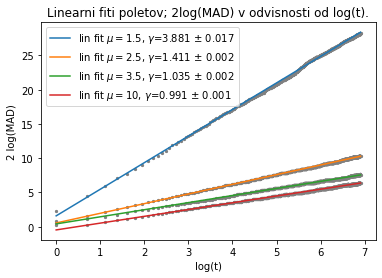

In [950]:
def draw_lin_fit(x,y,plt,mu):
    popt, pcov = optimize.curve_fit(linear_func, x, y)
    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    print(k)

    y_lin = linear_func(x, popt[0], popt[1])

    plt.plot(x, y_lin,
             label=fr'lin fit $\mu = {mu}$, $\gamma$={round(k[0],3)} $\pm$ {round(k[1],3)}')

def get_x_MAD(mu, plt):
    x, MADs = flight_mad(1000, 1000, mu)
    x, y = np.log(x[1:]), 2*np.log(MADs[1:])
    plt.scatter(x, y,c='gray',s=5,alpha=1)
    draw_lin_fit(x,y,plt,mu)


get_x_MAD(1.5, plt)
get_x_MAD(2.5, plt)
get_x_MAD(3.5, plt)
get_x_MAD(10, plt)

plt.xlabel('log(t)')
plt.ylabel('2 log(MAD)')
plt.title('Linearni fiti poletov; 2log(MAD) v odvisnosti od log(t).')
plt.legend()
plt.savefig(f"./outputs/lin_fit_poleti.pdf", bbox_inches='tight')
plt.show()


(1.8988616893065071, 0.004388819637336357)


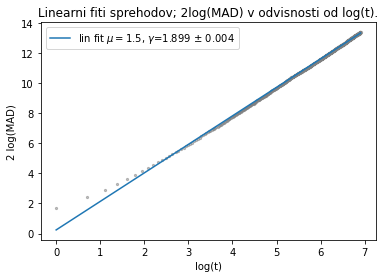

In [1022]:
def draw_lin_fit(x, y, plt, mu):
    popt, pcov = optimize.curve_fit(linear_func, x, y)
    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    print(k)

    y_lin = linear_func(x, popt[0], popt[1])

    plt.plot(x, y_lin,
             label=fr'lin fit $\mu = {mu}$, $\gamma$={round(k[0],3)} $\pm$ {round(k[1],3)}')


def get_x_MAD(mu, plt):
    x, MADs = walk_mad(1000, 1000, mu)
    x, y = np.log(x[1:]), 2*np.log(MADs[1:])
    plt.scatter(x, y,c='gray',s=5, alpha=0.5)
    draw_lin_fit(x, y, plt, mu)


get_x_MAD(1.5, plt)
# get_x_MAD(2.5, plt)
# get_x_MAD(3.5, plt)
# get_x_MAD(10, plt)

plt.xlabel('log(t)')
plt.ylabel('2 log(MAD)')
plt.title('Linearni fiti sprehodov; 2log(MAD) v odvisnosti od log(t).')
plt.legend()
# plt.savefig(f"./outputs/lin_fit_sprehodi.pdf", bbox_inches='tight')
plt.show()


100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


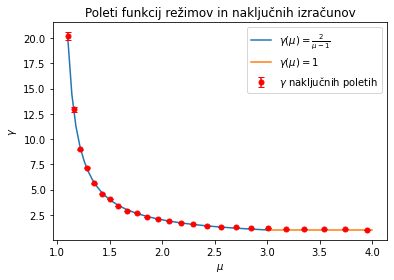

In [952]:
mus = np.linspace(0,0.45, num=25)

mus = (np.power(20,mus)) + 0.1

Ks = []
Ks_err = []

for mu in tqdm(mus):
    x, MADs = flight_mad(1000, 1000, mu)

    x, y = np.log(x[1:]), 2*np.log(MADs[1:])

    popt, pcov = optimize.curve_fit(linear_func, x, y)

    # print(popt, np.sqrt(np.diag(pcov)))

    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    Ks.append(popt[0])
    Ks_err.append(absolute_errs[0])

x_1 = np.linspace(1.1,3)
plt.plot(x_1, flight_gamma(x_1), label=r'$\gamma(\mu) = \frac{2}{\mu -1}$')

x_2 = np.linspace(3,4)
plt.plot(x_2, flight_gamma(x_2), label=r'$\gamma(\mu) = 1$')

plt.errorbar(mus, Ks, yerr=Ks_err, capsize=3, ecolor='r',ms=5, fmt='ro', label='$\gamma$ naključnih poletih')

plt.xlabel(r'$\mu$')
plt.ylabel(r'$\gamma$')
plt.title("Poleti funkcij režimov in naključnih izračunov")

plt.legend()
plt.savefig(f"./outputs/poleti_primerjava_model.pdf", bbox_inches='tight')
plt.show()


## Se fit za walk

100%|██████████| 25/25 [02:44<00:00,  6.59s/it]


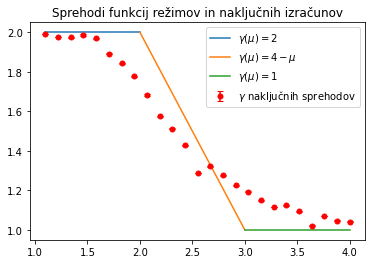

In [974]:
mus = np.linspace(1.1, 4, num=25)

Ks = []
Ks_err = []

for mu in tqdm(mus):
    x, MADs = walk_mad(1000, 1000, mu)

    x, y = np.log(x[50:]), 2*np.log(MADs[50:])

    popt, pcov = optimize.curve_fit(linear_func, x, y)

    # print(popt, np.sqrt(np.diag(pcov)))

    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    Ks.append(popt[0])
    Ks_err.append(absolute_errs[0])

x_1 = np.linspace(1.1, 2)
plt.plot(x_1, walk_gamma(x_1), label=r'$\gamma(\mu) = 2$')

x_2 = np.linspace(2, 3, num=2)
plt.plot(x_2, walk_gamma(x_2), label=r'$\gamma(\mu) = 4 - \mu$')

x_3 = np.linspace(3, 4)
plt.plot(x_3, walk_gamma(x_3), label=r'$\gamma(\mu) = 1$')


plt.errorbar(mus, Ks, yerr=Ks_err, capsize=3,ms=5, ecolor='r',
             fmt='ro', label='$\gamma$ naključnih sprehodov')
plt.title("Sprehodi funkcij režimov in naključnih izračunov")
plt.legend()
plt.savefig(f"./outputs/sprehodi_primerjava_model1.pdf", bbox_inches='tight')
plt.show()


## Porazdelitvena funkcija

Iz slajda na strani 14 mas formulo pa pac navodila

## Dodatna naloga

In [1018]:
def walk_mad_dodatna(M, N, mu, alpha, draw=False, draw_time=False):
    X = np.zeros((M, N))
    Y = np.zeros((M, N))
    L_ii = np.zeros((2*M, N))
    Phi_ii = np.zeros((2*M, N))

    vt_0 = 1.5
    vt = 1.5

    # najprej zgenereram use dolzine
    # tuki jih zgenereram mal vec da jih nebo premal nakonc
    for m in range(1, 2*M):
        # phi = np.random.random(N) * 2 * np.pi
        # # l_i = l(P, inverseP, np.random.random(), 1, mu)
        # l_i = np.random.pareto(mu-1, size=N) + 1
        Phi_ii[m] = np.random.random(N) * 2 * np.pi
        L_ii[m] = np.random.pareto(mu-1, size=N) + 1
        # X[m] = X[m-1] + l_i * np.cos(phi)
        # Y[m] = Y[m-1] + l_i * np.sin(phi)

    # kr uzemmo za mad M korakov, itak nima veze ker so velke cifre
    MADs = np.zeros(M)

    # za vsako meritev posebi
    for n in range(N):
        m = 0
        orig_m = 0
        leftover_l = 0
        leftover_phi = 0
        for m in range(M-1):
            if not orig_m < 2*M:
                break
            m += 1

            trapping_time = np.random.pareto(alpha)
            for i in range(int(trapping_time / vt_0)):
                if not m < M:
                    break
                X[m][n] = X[m-1][n]
                Y[m][n] = Y[m-1][n]
                m += 1

            vt = vt_0 - trapping_time%vt_0

            if not m < M:
                break

            # ce je vecji leftover, se sam premaknemo naprej
            if leftover_l > vt:
                X[m][n] = X[m-1][n] + vt * np.cos(leftover_phi)
                Y[m][n] = Y[m-1][n] + vt * np.sin(leftover_phi)
                leftover_l -= vt

            # ce je mansi leftover ga porabmo ceuga, in gremo na sledn korak
            else: #elif leftover_l < vt:
                X[m][n] = X[m-1][n] + leftover_l * np.cos(leftover_phi)
                Y[m][n] = Y[m-1][n] + leftover_l * np.sin(leftover_phi)

                vt_rest = vt - leftover_l
                leftover_l = 0

                #? ce je dolzina naslednga koraka vecja kt predvidena hitrost
                #? se sam premaknemo za njo naprej in gremo na nasledn korak
                if L_ii[orig_m][n] > vt_rest:
                    X[m][n] = X[m-1][n] + vt_rest * np.cos(Phi_ii[orig_m][n])
                    Y[m][n] = Y[m-1][n] + vt_rest * np.sin(Phi_ii[orig_m][n])

                    leftover_l = L_ii[orig_m][n] - vt_rest
                    leftover_phi = Phi_ii[orig_m][n]

                    orig_m += 1

                #? se ce slucajn zgodi, da je vec naslednih korakov mansih kt vt
                #? pac to sam pomen, da jih mors vec skp sestet
                else:
                    # vt_rest = vt
                    while True:
                        if not orig_m < 2*M:
                            break

                        if L_ii[orig_m][n] < vt_rest:
                            X[m][n] = X[m-1][n] + L_ii[orig_m][n] * \
                                np.cos(Phi_ii[orig_m][n])
                            Y[m][n] = Y[m-1][n] + L_ii[orig_m][n] * \
                                np.sin(Phi_ii[orig_m][n])

                            vt_rest -= L_ii[orig_m][n]
                            orig_m += 1

                        else:
                            X[m][n] = X[m-1][n] + vt_rest * \
                                np.cos(Phi_ii[orig_m][n])
                            Y[m][n] = Y[m-1][n] + vt_rest * \
                                np.sin(Phi_ii[orig_m][n])

                            leftover_l = L_ii[orig_m][n] - vt_rest
                            leftover_phi = Phi_ii[orig_m][n]

                            break


    for m in range(M):
        MADs[m] = np.sqrt(stats.median_abs_deviation(
            X[m])**2 + stats.median_abs_deviation(Y[m])**2)

    MADs = MADs[MADs != 0]

    if draw:
        plt.plot(X[:, 0], Y[:, 0], label=f'M = {M}; $\mu$ = {mu}')
        plt.title(f'2D graf sprehoda z $\mu$ = {mu}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    if draw_time:
        plt.plot(np.arange(len(X[:, 0])), X[:, 0])
        plt.show()

    return np.arange(len(MADs)), MADs


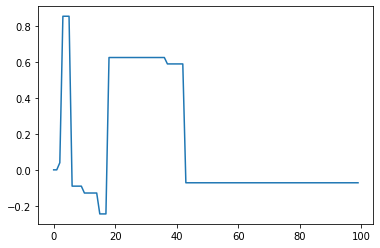

(array([], dtype=int64), array([], dtype=float64))

In [1017]:
walk_mad_dodatna(100,1,3, 1.5,draw_time=True)

(1.93280314760314, 0.004553713032843844)
(1.9070922302252342, 0.004454897220966785)
(1.3097478515517271, 0.002140245914215843)
(1.3792166795588008, 0.0029683121348117346)


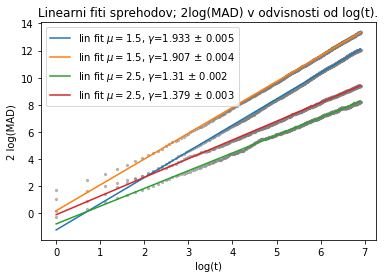

In [1023]:
def draw_lin_fit_dodatna(x, y, plt, mu):
    popt, pcov = optimize.curve_fit(linear_func, x, y)
    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    print(k)

    y_lin = linear_func(x, popt[0], popt[1])

    plt.plot(x, y_lin,
             label=fr'lin fit $\mu = {mu}$, $\gamma$={round(k[0],3)} $\pm$ {round(k[1],3)}')


def get_x_MAD_dodatna(mu, plt):
    x, MADs = walk_mad_dodatna(1000, 1000, mu, 1.5)
    x, y = np.log(x[1:]), 2*np.log(MADs[1:])
    plt.scatter(x, y, c='gray', s=5, alpha=0.5)
    draw_lin_fit_dodatna(x, y, plt, mu)


get_x_MAD_dodatna(1.5, plt)
get_x_MAD(1.5, plt)
get_x_MAD_dodatna(2.5, plt)
get_x_MAD(2.5, plt)
get_x_MAD_dodatna(10, plt)
get_x_MAD(10, plt)
# get_x_MAD_dodatna(3.5, plt)
# get_x_MAD_dodatna(10, plt)

plt.xlabel('log(t)')
plt.ylabel('2 log(MAD)')
plt.title('Linearni fiti sprehodov; 2log(MAD) v odvisnosti od log(t).')
plt.legend()
# plt.savefig(f"./outputs/lin_fit_sprehodi.pdf", bbox_inches='tight')
plt.show()


100%|██████████| 25/25 [03:08<00:00,  7.54s/it]


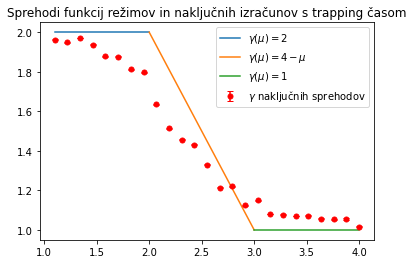

In [1019]:
mus = np.linspace(1.1, 4, num=25)

Ks = []
Ks_err = []

for mu in tqdm(mus):
    x, MADs = walk_mad_dodatna(1000, 1000, mu, 1.5)

    x, y = np.log(x[50:]), 2*np.log(MADs[50:])

    popt, pcov = optimize.curve_fit(linear_func, x, y)

    # print(popt, np.sqrt(np.diag(pcov)))

    absolute_errs = popt * np.sqrt(np.diag(pcov))
    k = (popt[0], absolute_errs[0])
    Ks.append(popt[0])
    Ks_err.append(absolute_errs[0])

x_1 = np.linspace(1.1, 2)
plt.plot(x_1, walk_gamma(x_1), label=r'$\gamma(\mu) = 2$')

x_2 = np.linspace(2, 3, num=2)
plt.plot(x_2, walk_gamma(x_2), label=r'$\gamma(\mu) = 4 - \mu$')

x_3 = np.linspace(3, 4)
plt.plot(x_3, walk_gamma(x_3), label=r'$\gamma(\mu) = 1$')


plt.errorbar(mus, Ks, yerr=Ks_err, capsize=3, ms=5, ecolor='r',
             fmt='ro', label='$\gamma$ naključnih sprehodov')
plt.title("Sprehodi funkcij režimov in naključnih izračunov s trapping časom")
plt.legend()
plt.savefig(f"./outputs/sprehodi_primerjava_model_trapping.pdf", bbox_inches='tight')
plt.show()
